In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from datetime import datetime
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import cohen_kappa_score
from pathlib import Path

In [53]:
json_base = Path("./data")
json_file = Path("ASNE_2024-11-27T20-56-14-254Z_experimental_data.json")
json_path = json_base / json_file
print(json_path)

data/ASNE_2024-11-27T20-56-14-254Z_experimental_data.json


In [54]:
# Read JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Create DataFrames
gaze_df = pd.DataFrame(data['gazeData'])
trial_df = pd.DataFrame(data['trialData'])

# Process gaze data relative to trial timings
gaze_df['timestamp'] = trial_df['startTime'].iloc[0] + (gaze_df['time'] * 1000)

def check_target_position(x, y):
    left_region = x < 333
    center_region = (x >= 333) & (x < 666)
    right_region = x >= 666
    return 'left' if left_region else 'center' if center_region else 'right'

# Add position information to gaze data
gaze_df['position'] = gaze_df.apply(lambda row: check_target_position(row['x'], row['y']), axis=1)

In [55]:
# Read JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Create DataFrames
gaze_df = pd.DataFrame(data['gazeData'])
trial_df = pd.DataFrame(data['trialData'])

# Process gaze data relative to trial timings
gaze_df['timestamp'] = trial_df['startTime'].iloc[0] + (gaze_df['time'] * 1000)

def check_target_position(x, y):
    left_region = x < 333
    center_region = (x >= 333) & (x < 666)
    right_region = x >= 666
    return 'left' if left_region else 'center' if center_region else 'right'

# Add position information to gaze data
gaze_df['position'] = gaze_df.apply(lambda row: check_target_position(row['x'], row['y']), axis=1)

def create_gaze_plot(gaze_df, figsize=(10, 8)):
    """
    Creates a scatter plot of gaze points with overlapping intensity visualization.
    
    Parameters:
    gaze_df (pd.DataFrame): DataFrame containing gaze data with x and y coordinates
    figsize (tuple): Figure size in inches (width, height)
    """
    plt.style.use('dark_background')  # Set black background
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create scatter plot with overlapping intensity
    scatter = ax.scatter(
        gaze_df['x'], 
        gaze_df['y'],
        c='yellow',      # Yellow dots
        alpha=0.3,       # Initial transparency
        s=50,            # Size in points (0.5 cm approximation)
        marker='o'
    )
    
    # Customize plot appearance
    ax.set_xlabel('Horizontal', color='white')
    ax.set_ylabel('Vertical', color='white')
    
    # Remove tick marks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines white
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    
    # Ensure plot remains tight to the data
    plt.tight_layout()
    
    return fig, ax

In [56]:
def preprocess_data(trial_data, gaze_data):
    """
    Preprocess and validate trial and gaze data.
    """
    required_trial_columns = ['trialNumber', 'startTime', 'endTime', 'positions', 'type']
    required_gaze_columns = ['x', 'y', 'time']
    
    # Check for required columns
    for col in required_trial_columns:
        if col not in trial_data.columns:
            raise ValueError(f"Missing required column in trial_data: {col}")
    for col in required_gaze_columns:
        if col not in gaze_data.columns:
            raise ValueError(f"Missing required column in gaze_data: {col}")
    
    # Handle missing values for scalar columns
    scalar_fill = {'type': 'unknown', 'startTime': 0, 'endTime': 0}
    trial_data.fillna(value=scalar_fill, inplace=True)

    # Handle missing values for list columns
    if 'positions' in trial_data.columns:
        trial_data['positions'] = trial_data['positions'].apply(lambda x: x if isinstance(x, list) else [])
    
    # Drop rows with missing values in gaze data
    gaze_data.dropna(inplace=True)
    
    # Validate start and end times
    invalid_trials = trial_data[trial_data['startTime'] >= trial_data['endTime']]
    if not invalid_trials.empty:
        raise ValueError(f"Invalid trials found with startTime >= endTime:\n{invalid_trials}")
    
    # Validate timestamps in gaze_data
    if (gaze_data['time'] < 0).any():
        raise ValueError("Negative timestamps found in gaze_data.")
    
    # Validate 'positions' column structure
    if not trial_data['positions'].apply(lambda p: isinstance(p, list) and all('position' in pos and 'isTarget' in pos for pos in p)).all():
        raise ValueError("Invalid structure in 'positions' column of trial_data.")
    
    return trial_data, gaze_data


def analyze_first_fixations(gaze_df, trial_df):
    """
    Analyze first fixations for each trial.
    """
    first_fixations = []

    for _, trial in trial_df.iterrows():
        # Filter gaze data for the trial's time window
        trial_gazes = gaze_df[
            (gaze_df['timestamp'] >= trial['startTime']) &
            (gaze_df['timestamp'] <= trial['endTime'])
        ]
        
        if trial_gazes.empty:
            print(f"No gaze data found for trial {trial['trialNumber']}")
            continue

        # Extract the target position safely
        try:
            target_pos = next(pos['position'] for pos in trial['positions'] if pos.get('isTarget'))
        except StopIteration:
            print(f"No target position found for trial {trial['trialNumber']}")
            continue

        # Record the first fixation and correctness
        first_pos = trial_gazes['position'].iloc[0]
        first_fixations.append({
            'trial': trial['trialNumber'],
            'type': trial['type'],
            'first_position': first_pos,
            'target_position': target_pos,
            'correct_first_fixation': first_pos == target_pos
        })

    if not first_fixations:
        raise ValueError("No valid data to calculate first fixations.")
    
    # Convert results to DataFrame
    ff_df = pd.DataFrame(first_fixations)

    # Statistical tests
    ff_stats = {
        'accuracy': ff_df['correct_first_fixation'].mean(),
        'chance_level': 1 / 3,  # Assuming 3 positions
        'binomial_test': stats.binomtest(
            k=ff_df['correct_first_fixation'].sum(),
            n=len(ff_df),
            p=1 / 3  # Chance level
        ),
        'chi_square': stats.chi2_contingency(
            pd.crosstab(ff_df['type'], ff_df['correct_first_fixation'])
        )
    }
    
    return ff_df, ff_stats

def analyze_trial_gaze(json_file):
    """
    Comprehensive analysis of eye gaze data, including statistical tests for first fixations.
    """
    # Read JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Create DataFrames
    gaze_df = pd.DataFrame(data['gazeData'])
    trial_df = pd.DataFrame(data['trialData'])

    # Preprocess data
    trial_df, gaze_df = preprocess_data(trial_df, gaze_df)

    # Calculate timestamps
    gaze_df['timestamp'] = trial_df['startTime'].iloc[0] + (gaze_df['time'] * 1000)

    # Define gaze position mapping function
    def check_target_position(x, y):
        left_region = x < 333
        center_region = (x >= 333) & (x < 666)
        right_region = x >= 666
        return 'left' if left_region else 'center' if center_region else 'right'

    # Map positions to gaze data
    gaze_df['position'] = gaze_df.apply(lambda row: check_target_position(row['x'], row['y']), axis=1)

    # Analyze first fixations
    first_fixation_df, ff_stats = analyze_first_fixations(gaze_df, trial_df)

    # Compile results
    results = {
        'gaze_df': gaze_df,
        'trial_df': trial_df,
        'first_fixation_analysis': {
            'data': first_fixation_df,
            'stats': ff_stats
        }
    }
    
    return results


In [57]:
def analyze_target_distractor_time(gaze_df, trial_df):
    """
    Comprehensive diagnostic analysis of target vs distractor gaze times.

    Parameters:
    gaze_df (pd.DataFrame): DataFrame containing gaze data
    trial_df (pd.DataFrame): DataFrame containing trial information

    Returns:
    dict: Detailed analysis results with summary, statistical tests, and visualization
    """

    # Validation checks
    print("Data Validation:")
    print(f"Gaze DataFrame shape: {gaze_df.shape}")
    print(f"Trial DataFrame shape: {trial_df.shape}")
    print("\nGaze DataFrame Columns:", list(gaze_df.columns))
    print("\nTrial DataFrame Columns:", list(trial_df.columns))

    # Ensure required columns exist
    required_gaze_columns = ['timestamp', 'position']
    required_trial_columns = ['startTime', 'endTime', 'positions', 'trialNumber', 'type']

    for col in required_gaze_columns:
        if col not in gaze_df.columns:
            raise ValueError(f"Missing required column in gaze data: {col}")

    for col in required_trial_columns:
        if col not in trial_df.columns:
            raise ValueError(f"Missing required column in trial data: {col}")

    # Compute time spent in each position for each trial
    position_times = []

    # Diagnostic print for first few trials
    print("\nFirst 3 Trials Diagnostic:")
    for idx, trial in trial_df.iterrows():
        print(f"\nTrial {trial['trialNumber']} Details:")
        print(f"Start Time: {trial['startTime']}")
        print(f"End Time: {trial['endTime']}")
        print("Positions:")
        for pos in trial['positions']:
            print(f"  - {pos}")

    # Main analysis loop
    for _, trial in trial_df.iterrows():
        # Filter gaze data for this specific trial
        trial_gazes = gaze_df[
            (gaze_df['timestamp'] >= trial['startTime']) &
            (gaze_df['timestamp'] <= trial['endTime'])
        ]

        # Print trial gaze diagnostic
        print(f"\nTrial {trial['trialNumber']} Gaze Diagnostic:")
        print(f"Total gaze samples: {len(trial_gazes)}")
        print("Gaze position distribution:")
        print(trial_gazes['position'].value_counts())

        # Identify target and distractor positions
        try:
            target_pos = next(pos['position'] for pos in trial['positions'] if pos.get('isTarget', False))
            distractor_positions = [pos['position'] for pos in trial['positions'] if not pos.get('isTarget', False)]
        except Exception as e:
            print(f"Error identifying target/distractor positions: {e}")
            print("Trial positions:", trial['positions'])
            continue

        # Compute time spent in each position
        total_samples = len(trial_gazes)
        
        # Sanity checks
        if total_samples == 0:
            print(f"Warning: No gaze samples for trial {trial['trialNumber']}")
            continue

        target_samples = len(trial_gazes[trial_gazes['position'] == target_pos])
        distractor_samples = len(trial_gazes[trial_gazes['position'].isin(distractor_positions)])

        position_times.append({
            'trial_number': trial['trialNumber'],
            'trial_type': trial['type'],
            'target_position': target_pos,
            'distractor_positions': distractor_positions,
            'target_time': target_samples / total_samples,
            'distractor_time': distractor_samples / total_samples,
            'total_samples': total_samples
        })

    # Convert to DataFrame
    position_time_df = pd.DataFrame(position_times)

    # Final diagnostic print
    print("\nFinal Position Times DataFrame:")
    print(position_time_df)

    # If no valid trials, raise an error
    if position_time_df.empty:
        raise ValueError("No valid trials found for analysis")

    # Prepare results container
    analysis_results = {
        'raw_data': {
            'gaze_df': gaze_df,
            'trial_df': trial_df
        },
        'position_times': position_time_df,
        'overall_summary': {
            'total_trials': len(position_time_df),
            'mean_target_time': position_time_df['target_time'].mean(),
            'mean_distractor_time': position_time_df['distractor_time'].mean(),
            'median_target_time': position_time_df['target_time'].median(),
            'median_distractor_time': position_time_df['distractor_time'].median(),
            'trial_types': position_time_df['trial_type'].unique().tolist()
        },
        'trial_type_summary': position_time_df.groupby('trial_type').agg({
            'target_time': ['mean', 'median', 'std'],
            'distractor_time': ['mean', 'median', 'std']
        })
    }

    # Statistical tests
    try:
        # Wilcoxon signed-rank test
        wilcoxon_test = stats.wilcoxon(
            position_time_df['target_time'], 
            position_time_df['distractor_time']
        )
        
        # One-way ANOVA (only if more than one trial type)
        trial_types = position_time_df['trial_type'].unique()
        trial_type_anova = None
        if len(trial_types) > 1:
            trial_type_groups = [group['target_time'].values 
                                 for name, group in position_time_df.groupby('trial_type')]
            trial_type_anova = stats.f_oneway(*trial_type_groups)

        analysis_results['statistical_tests'] = {
            'wilcoxon_test': {
                'statistic': wilcoxon_test.statistic,
                'pvalue': wilcoxon_test.pvalue
            },
            'trial_type_anova': {
                'statistic': trial_type_anova.statistic if trial_type_anova else None,
                'pvalue': trial_type_anova.pvalue if trial_type_anova else None
            }
        }
    except Exception as e:
        print(f"Error in statistical tests: {e}")
        analysis_results['statistical_tests'] = None

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.style.use('default')  # Reset to default style for clarity

    # Create subplot grid
    gs = plt.GridSpec(2, 1)

    # Boxplot of target time by trial type (left subplot)
    plt.subplot(gs[0])
    if len(trial_types) > 1:
        sns.boxplot(x='trial_type', y='target_time', data=position_time_df)
        plt.title('Target Fixation Time by Trial Type')
        plt.xlabel('Trial Type')
        plt.ylabel('Fraction of Trial Time')
    else:
        plt.text(0.5, 0.5, 'Insufficient trial types\nfor boxplot', 
                 horizontalalignment='center', 
                 verticalalignment='center')
        plt.title('Target Fixation Time')

    # Bar plot comparing target vs distractor time (right subplot)
    plt.subplot(gs[1])
    summary_data = {
        'Target': position_time_df['target_time'].mean(),
        'Distractor': position_time_df['distractor_time'].mean()
    }
    plt.bar(summary_data.keys(), summary_data.values(), color=['green', 'red'])
    plt.title('Average Time Proportion')
    plt.ylabel('Fraction of Time')

    # Add statistical annotations if possible
    if analysis_results['statistical_tests']:
        # Wilcoxon test annotation
        w_stat = analysis_results['statistical_tests']['wilcoxon_test']['statistic']
        p_val = analysis_results['statistical_tests']['wilcoxon_test']['pvalue']
        plt.figtext(0.5, -0.05, 
                    f'Target vs Distractor Time (Wilcoxon): W = {w_stat:.2f}, p = {p_val:.4f}', 
                    ha='center')

        # ANOVA annotation (if applicable)
        if analysis_results['statistical_tests']['trial_type_anova']['pvalue'] is not None:
            plt.figtext(0.5, 0.02, 
                        f'Trial Type ANOVA: p = {analysis_results["statistical_tests"]["trial_type_anova"]["pvalue"]:.4f}', 
                        ha='center')

    plt.tight_layout()
    analysis_results['visualization'] = plt

    return analysis_results

# Example usage remains the same
"""
diagnostic_results = analyze_target_distractor_time(gaze_df, trial_df)

# Print overall summary
print(diagnostic_results['overall_summary'])

# Access trial type summary
print(diagnostic_results['trial_type_summary'])

# Show statistical test results
print(diagnostic_results['statistical_tests'])

# Show the visualization
diagnostic_results['visualization'].show()
"""

"\ndiagnostic_results = analyze_target_distractor_time(gaze_df, trial_df)\n\n# Print overall summary\nprint(diagnostic_results['overall_summary'])\n\n# Access trial type summary\nprint(diagnostic_results['trial_type_summary'])\n\n# Show statistical test results\nprint(diagnostic_results['statistical_tests'])\n\n# Show the visualization\ndiagnostic_results['visualization'].show()\n"

# Plot the Recorded Gaze Paths

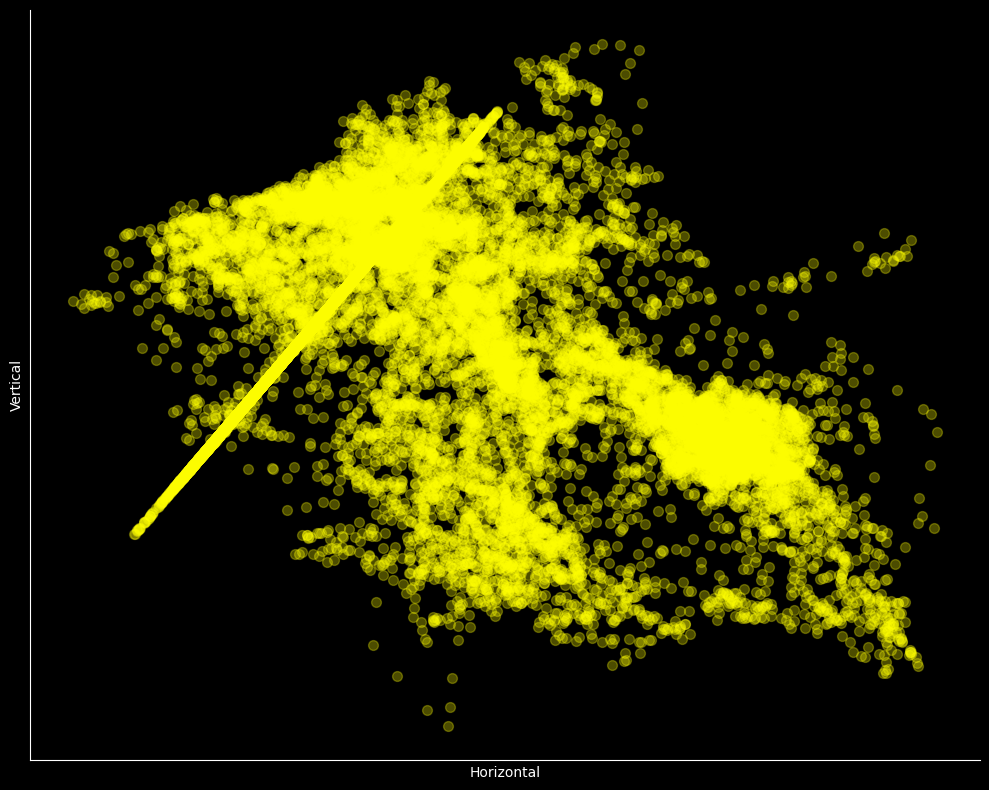

In [58]:
fig, ax = create_gaze_plot(gaze_df)

# To save the plot:
fig.savefig('gaze_plot.png', facecolor='black', edgecolor='none', bbox_inches='tight')
plt.show()

# Run Statistical Analyses on the Recorded Gaze by Trial (i.e., on/off target based on trial type)

In [59]:

# Usage:
# Run the analysis
results = analyze_trial_gaze(json_path)

# Print the statistical report
print(results['statistical_report'])

# Access specific statistical tests
print("\nDetailed First Fixation Statistics:")
print(results['first_fixation_analysis']['stats'])

print("\nResponse Time Post-hoc Analysis:")
print(results['response_times']['tukey_hsd'])

# Create visualizations with statistical annotations
plt.figure(figsize=(15, 10))

# Example: Response time by trial type with statistical significance
sns.boxplot(data=results['trial_df'], x='type', y='response_time')
plt.title(f"Response Time by Trial Type\np = {results['response_times']['type_effect'].pvalue:.4f}")
plt.show()

No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze data found for trial 1
No gaze 

ValueError: No valid data to calculate first fixations.

In [60]:
diagnostic_results = analyze_target_distractor_time(gaze_df, trial_df)

# Print overall summary
print(diagnostic_results['overall_summary'])

# Access trial type summary
print(diagnostic_results['trial_type_summary'])

# Show statistical test results
print(diagnostic_results['statistical_tests'])

# Show the visualization
diagnostic_results['visualization'].show()

Data Validation:
Gaze DataFrame shape: (27630, 5)
Trial DataFrame shape: (40, 7)

Gaze DataFrame Columns: ['x', 'y', 'time', 'timestamp', 'position']

Trial DataFrame Columns: ['trialNumber', 'type', 'startTime', 'object1', 'testObjects', 'positions', 'endTime']

First 3 Trials Diagnostic:

Trial 1 Details:
Start Time: 1732740373613
End Time: 1732740388622
Positions:
  - {'position': 'left', 'objectNum': 78, 'isTarget': False}
  - {'position': 'center', 'objectNum': 69, 'isTarget': False}
  - {'position': 'right', 'objectNum': 209, 'isTarget': True}

Trial 1 Details:
Start Time: 1732740388622
End Time: 1732740403634
Positions:
  - {'position': 'left', 'objectNum': 86, 'isTarget': False}
  - {'position': 'center', 'objectNum': 114, 'isTarget': True}
  - {'position': 'right', 'objectNum': 106, 'isTarget': False}

Trial 1 Details:
Start Time: 1732740403634
End Time: 1732740418648
Positions:
  - {'position': 'left', 'objectNum': 190, 'isTarget': True}
  - {'position': 'center', 'objectNum'

ValueError: No valid trials found for analysis

Trial 2 - Target Position: unknown
Gaze positions for Trial 2: ['center' 'right']


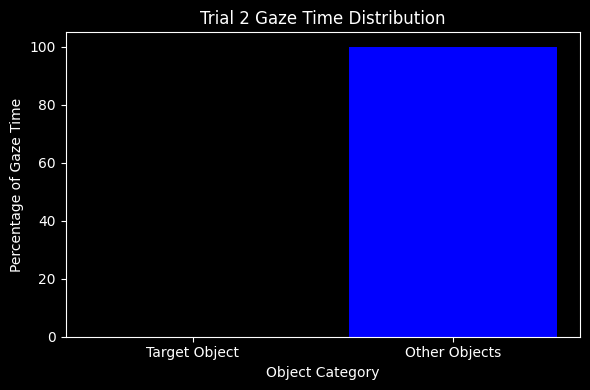

Trial 3 - Target Position: unknown
Gaze positions for Trial 3: ['right']


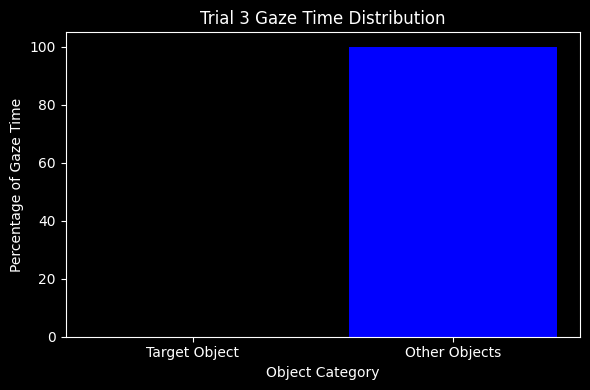

Trial 4 - Target Position: unknown
Gaze positions for Trial 4: ['right' 'center']


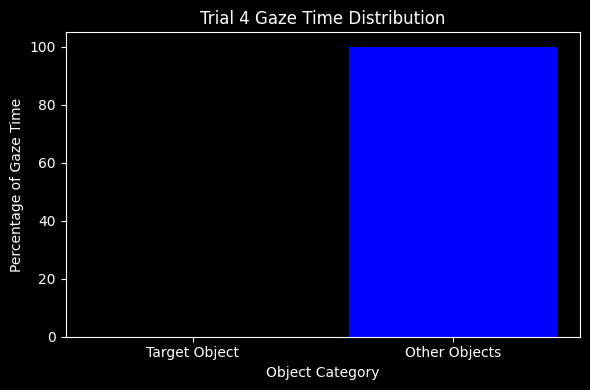

Trial 5 - Target Position: unknown
Gaze positions for Trial 5: ['right' 'center' 'left']


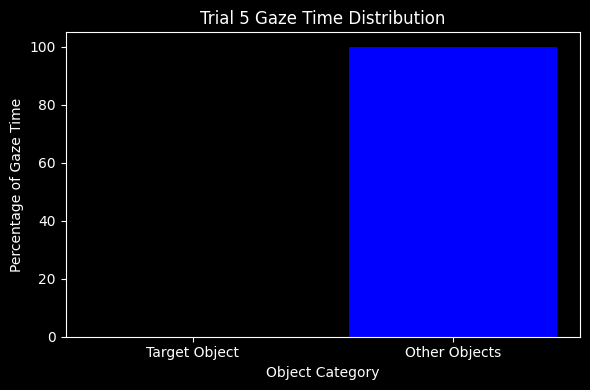

Trial 6 - Target Position: unknown
Gaze positions for Trial 6: ['right' 'center' 'left']


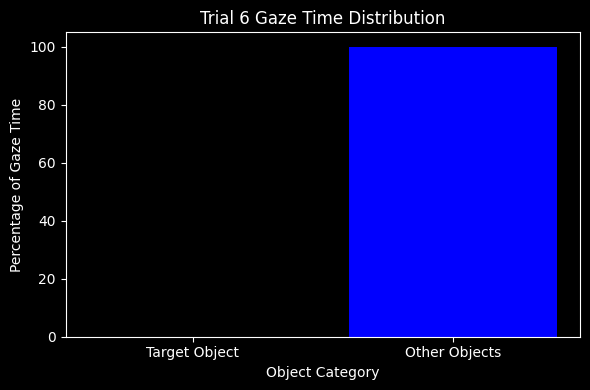

Trial 7 - Target Position: unknown
Gaze positions for Trial 7: ['center' 'right']


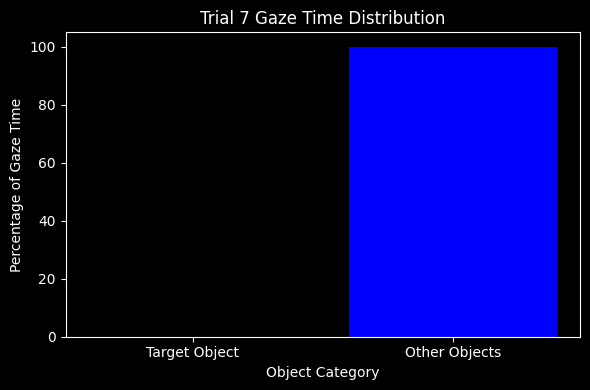

Trial 8 - Target Position: unknown
Gaze positions for Trial 8: ['right' 'center']


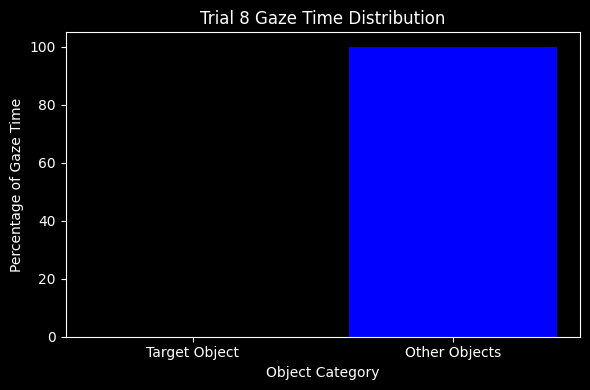

Trial 9 - Target Position: unknown
Gaze positions for Trial 9: ['center' 'right' 'left']


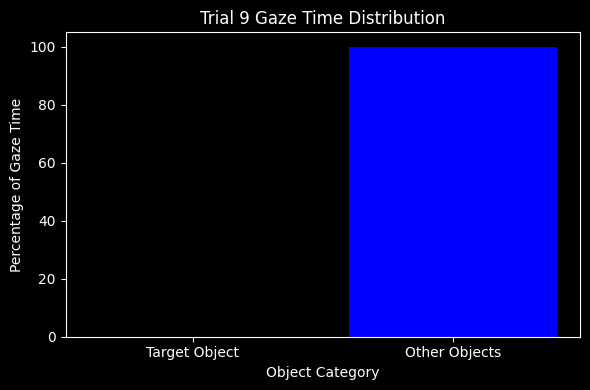

Trial 10 - Target Position: unknown
Gaze positions for Trial 10: ['center' 'right']


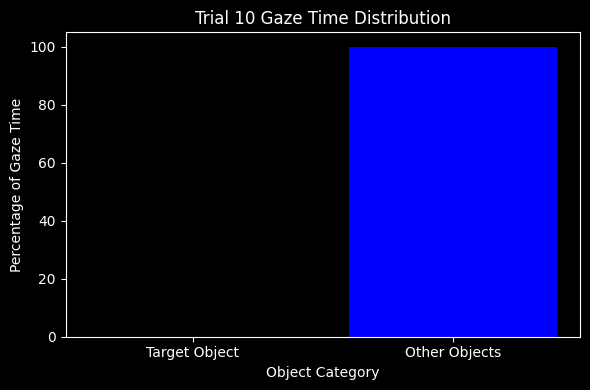

Trial 11 - Target Position: unknown
Gaze positions for Trial 11: ['center' 'right']


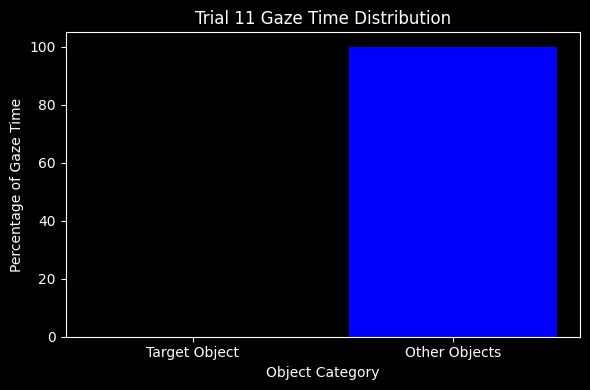

Trial 12 - Target Position: unknown
Gaze positions for Trial 12: ['right' 'center' 'left']


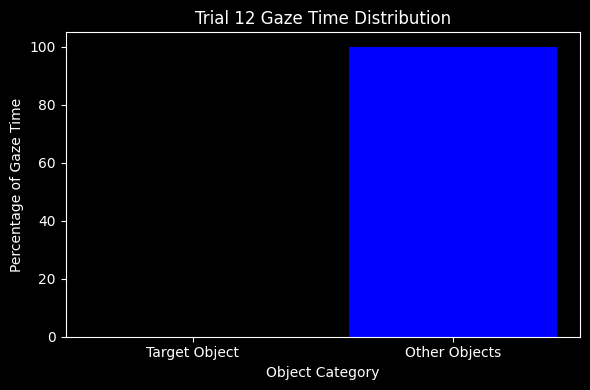

Trial 13 - Target Position: unknown
Gaze positions for Trial 13: ['left' 'center' 'right']


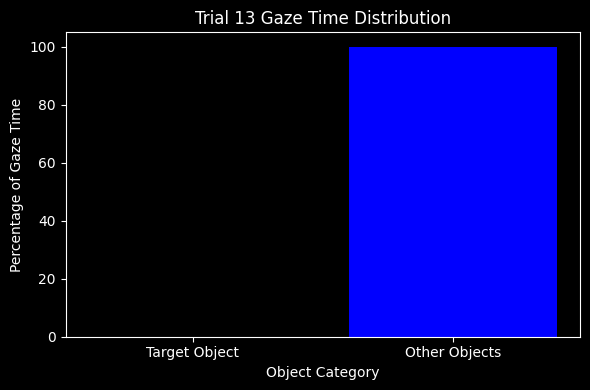

Trial 14 - Target Position: unknown
Gaze positions for Trial 14: ['right' 'center']


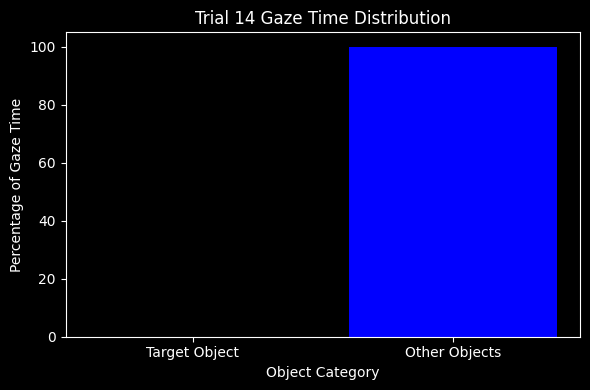

Trial 15 - Target Position: unknown
Gaze positions for Trial 15: ['right' 'center']


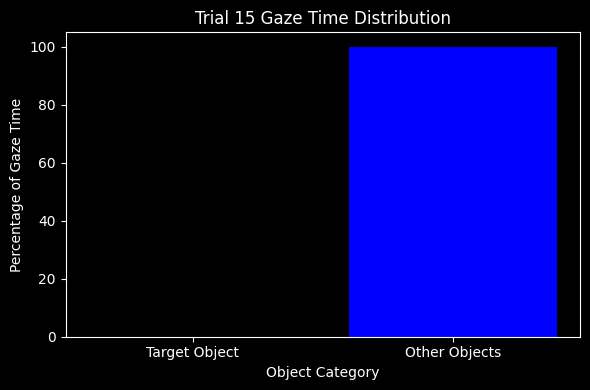

Trial 16 - Target Position: unknown
Gaze positions for Trial 16: ['right' 'center']


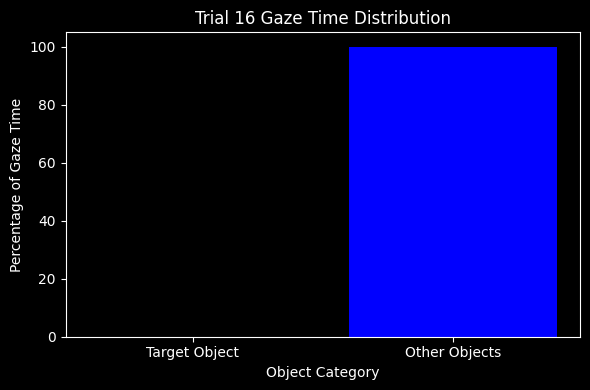

Trial 17 - Target Position: unknown
Gaze positions for Trial 17: ['center' 'right']


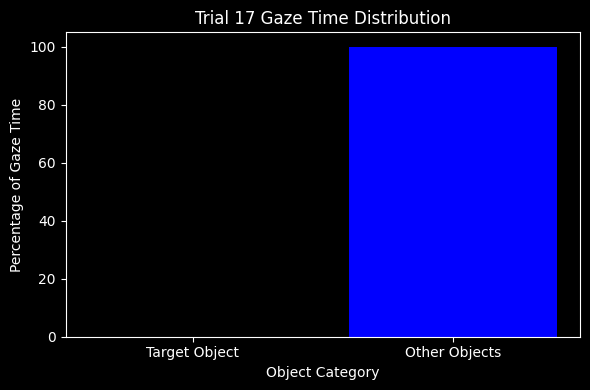

Trial 18 - Target Position: unknown
Gaze positions for Trial 18: ['center' 'right']


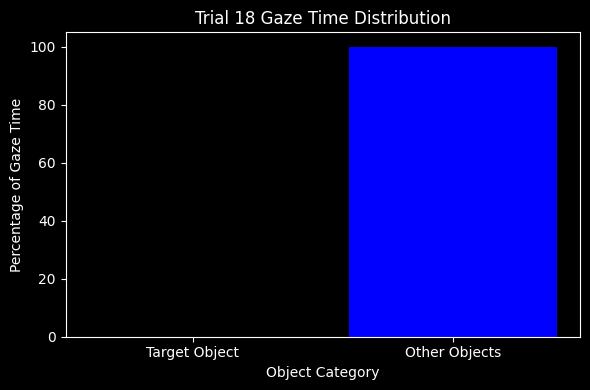

Trial 19 - Target Position: unknown
Gaze positions for Trial 19: ['center' 'right']


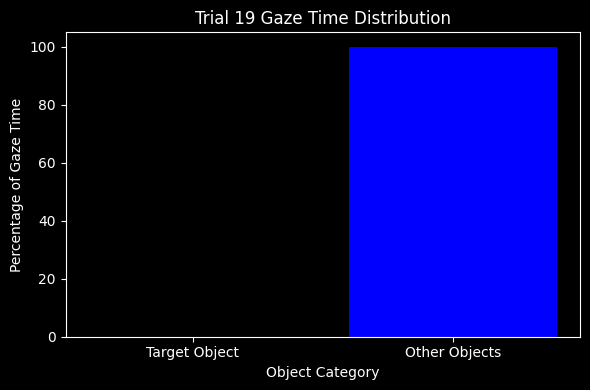

Trial 20 - Target Position: unknown
Gaze positions for Trial 20: ['right' 'center']


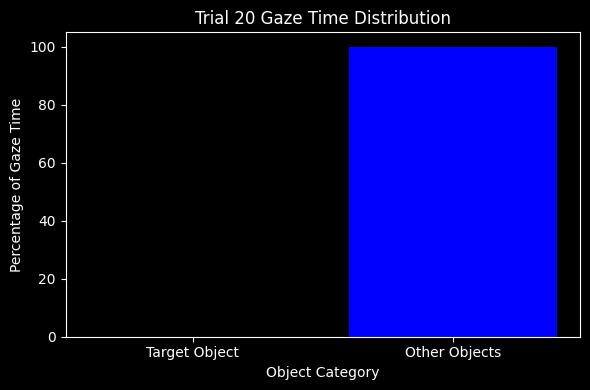

Trial 21 - Target Position: unknown
Gaze positions for Trial 21: ['center' 'right']


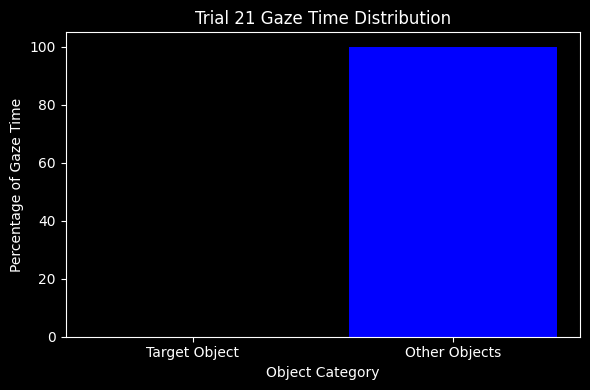

Trial 22 - Target Position: unknown
Gaze positions for Trial 22: ['center' 'right']


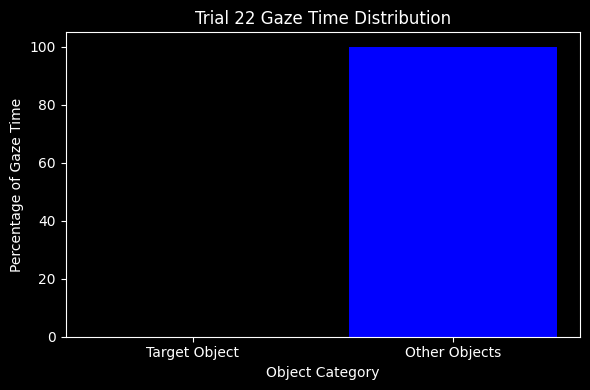

Trial 23 - Target Position: unknown
Gaze positions for Trial 23: ['center' 'right']


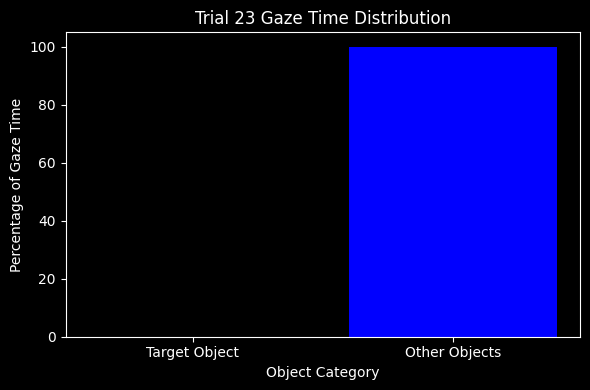

Trial 24 - Target Position: unknown
Gaze positions for Trial 24: ['center' 'right']


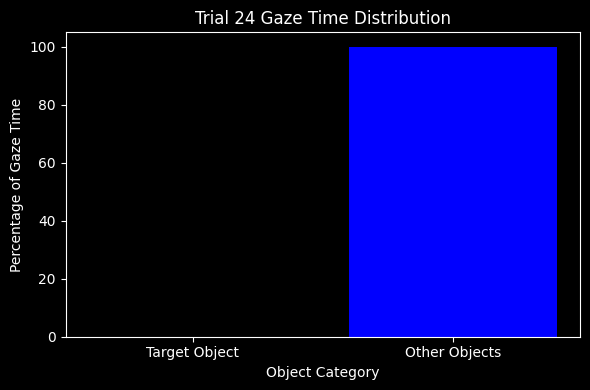

Trial 25 - Target Position: unknown
Gaze positions for Trial 25: ['right']


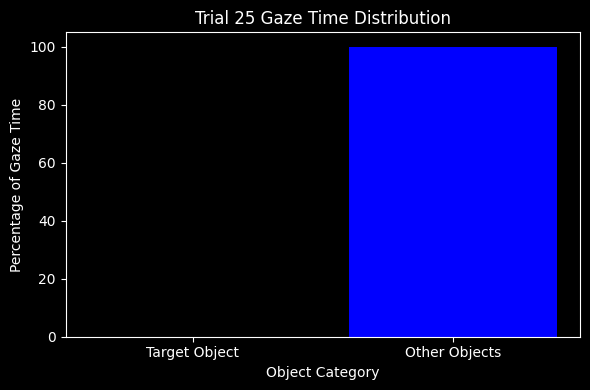

Trial 26 - Target Position: unknown
Gaze positions for Trial 26: ['right' 'center' 'left']


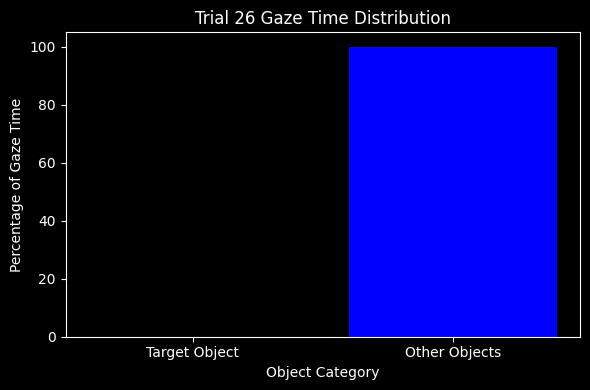

Trial 27 - Target Position: unknown
Gaze positions for Trial 27: ['right' 'center']


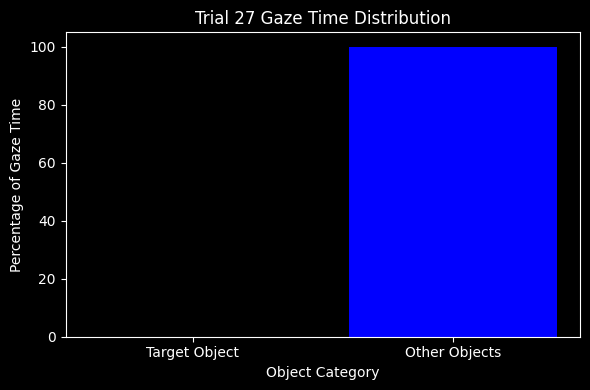

Trial 28 - Target Position: unknown
Gaze positions for Trial 28: ['right']


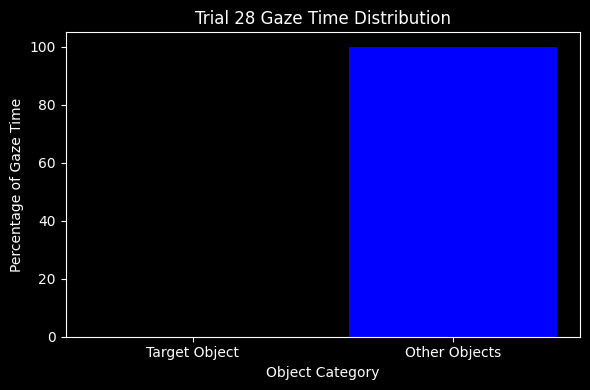

Trial 29 - Target Position: unknown
Gaze positions for Trial 29: ['right' 'center']


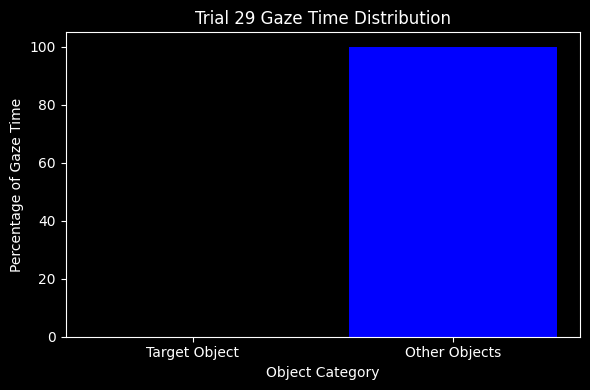

Trial 30 - Target Position: unknown
Gaze positions for Trial 30: ['right' 'center']


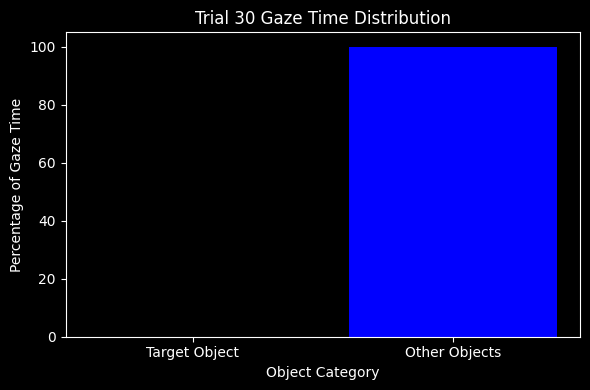

Trial 31 - Target Position: unknown
Gaze positions for Trial 31: ['center' 'right' 'left']


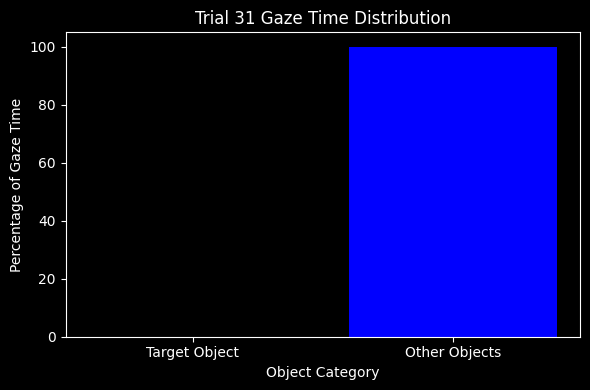

Trial 32 - Target Position: unknown
Gaze positions for Trial 32: ['right' 'center']


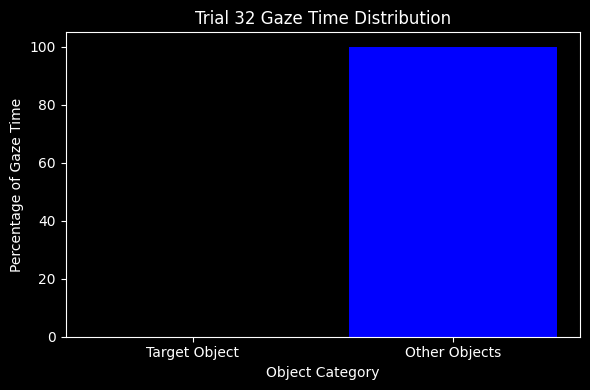

Trial 33 - Target Position: unknown
Gaze positions for Trial 33: ['right' 'center' 'left']


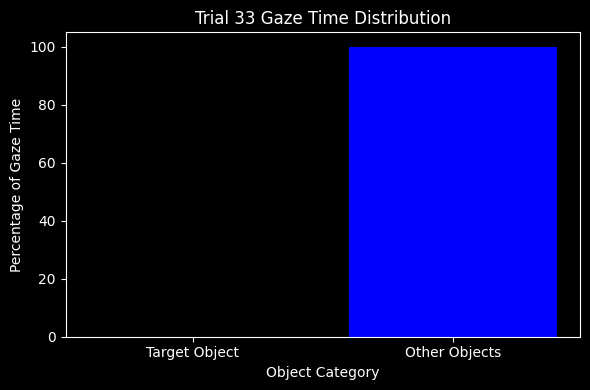

Trial 34 - Target Position: unknown
Gaze positions for Trial 34: ['center' 'right' 'left']


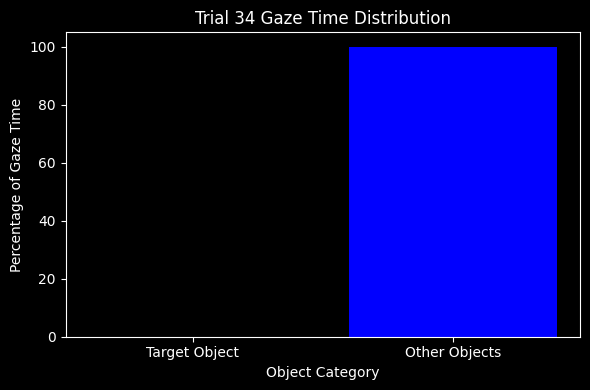

Trial 35 - Target Position: unknown
Gaze positions for Trial 35: ['right' 'center']


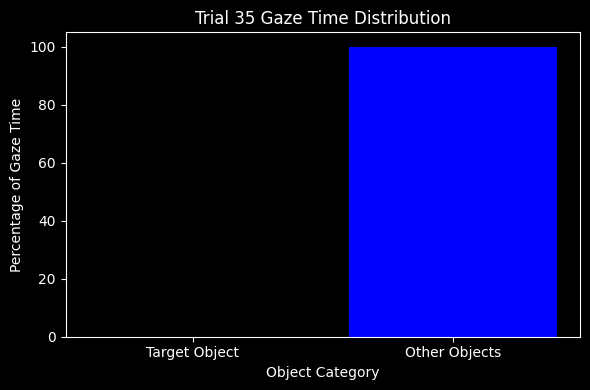

Trial 36 - Target Position: unknown
Gaze positions for Trial 36: ['right' 'center']


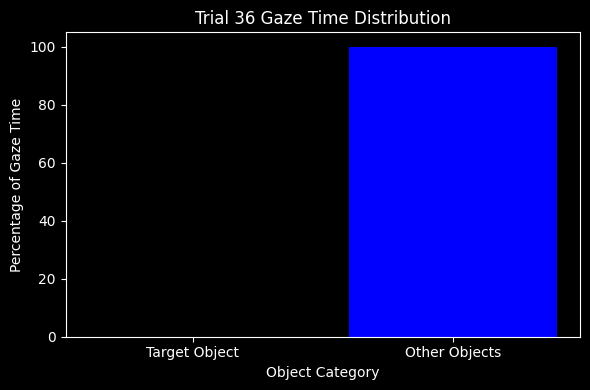

Trial 37 - Target Position: unknown
Gaze positions for Trial 37: ['center' 'right' 'left']


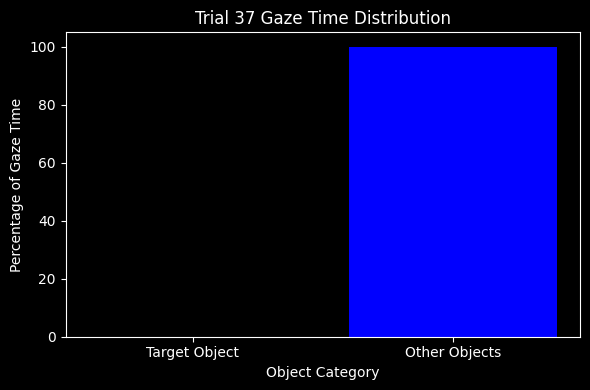

Trial 38 - Target Position: unknown
Gaze positions for Trial 38: ['right' 'center']


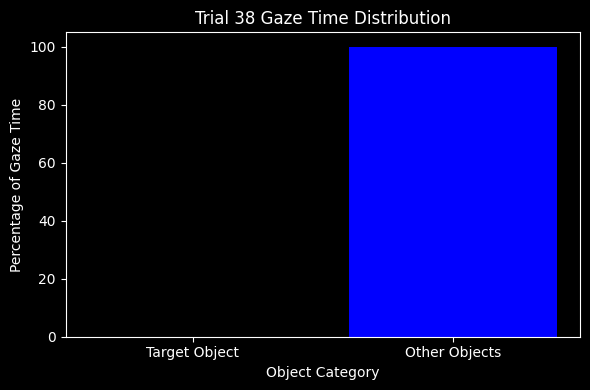

Trial 39 - Target Position: unknown
Gaze positions for Trial 39: ['right' 'center']


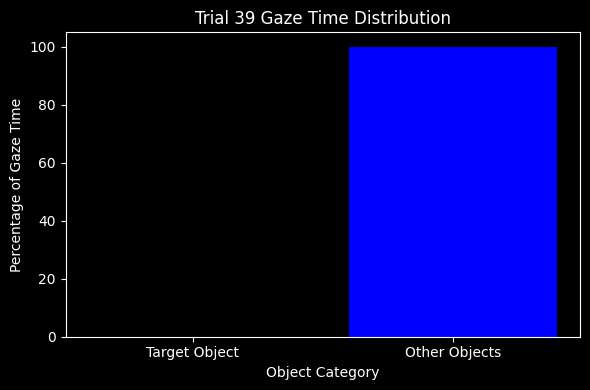

Trial 40 - Target Position: unknown
Gaze positions for Trial 40: ['center' 'right']


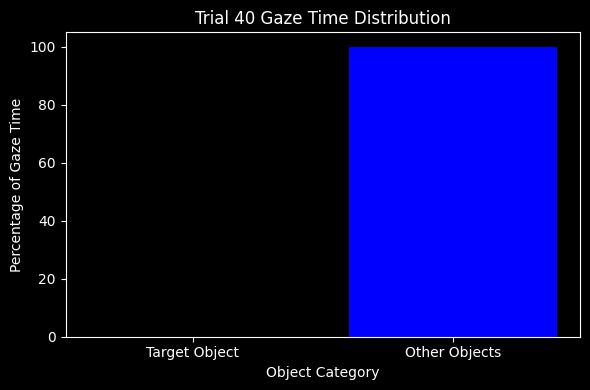

Trial-wise plots generated.


In [83]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_gaze_time(json_path):
    # Read JSON data
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Create DataFrames
    gaze_df = pd.DataFrame(data['gazeData'])
    trial_df = pd.DataFrame(data['trialData'])
    
    # Modify timestamp calculation
    first_trial_start = trial_df['startTime'].iloc[0]
    gaze_df['timestamp'] = first_trial_start + gaze_df['time']
    
    def check_target_position(x, y):
        """Determine which region the gaze is in."""
        left_region = x < 333
        center_region = (x >= 333) & (x < 666)
        right_region = x >= 666
        return 'left' if left_region else 'center' if center_region else 'right'
    
    # Add position information to gaze data
    gaze_df['position'] = gaze_df.apply(lambda row: check_target_position(row['x'], row['y']), axis=1)
    
    # Detailed trial-by-trial analysis
    for i, trial in trial_df.iterrows():
        # Filter gaze data for current trial
        trial_gazes = gaze_df[
            (gaze_df['timestamp'] >= trial['startTime']) & 
            (gaze_df['timestamp'] <= trial['endTime'])
        ]
        
        if not trial_gazes.empty:
            # Determine target position (assuming 'targetLocation' or a similar key exists)
            try:
                target_position = trial.get('targetLocation', trial.get('targetPosition', 'unknown'))
            except KeyError:
                print(f"Warning: Unable to determine target position for trial {i}")
                target_position = 'unknown'
            
            print(f"Trial {i+1} - Target Position: {target_position}")
            
            # Debugging: Check for target gaze position matching
            print(f"Gaze positions for Trial {i+1}: {trial_gazes['position'].unique()}")

            # Calculate gaze time for target object
            target_gaze = trial_gazes[trial_gazes['position'] == target_position]
            if len(trial_gazes) > 0:
                target_gaze_time = len(target_gaze) / len(trial_gazes) * 100
            else:
                target_gaze_time = 0
            
            # Calculate gaze time for other objects (non-target positions)
            other_gaze = trial_gazes[trial_gazes['position'] != target_position]
            if len(trial_gazes) > 0:
                other_gaze_time = len(other_gaze) / len(trial_gazes) * 100
            else:
                other_gaze_time = 0
            
            # Create a plot for each trial
            plt.figure(figsize=(6, 4))
            plt.bar(['Target Object', 'Other Objects'], [target_gaze_time, other_gaze_time], color=['red', 'blue'])
            plt.title(f'Trial {i+1} Gaze Time Distribution')
            plt.ylabel('Percentage of Gaze Time')
            plt.xlabel('Object Category')
            plt.tight_layout()
            plt.show()
    
    # Return a final summary of gaze times
    return 'Trial-wise plots generated.'

# Example usage (assuming json_path is defined)
print(analyze_gaze_time(json_path))
